<a href="https://colab.research.google.com/github/rland93/pendsim/blob/master/notebooks/PID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Set to True if you are running this notebook from Google Colab.

In [18]:
GOOGLE_COLAB = True

In [19]:
if not GOOGLE_COLAB:
    %cd ../
else:
    !pip install pendsim

# PID Tuning

This notebook contains a basic example for running the package with a PID controller.

Arrange imports

In [20]:
from pendsim import sim, controller, viz
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

Create a pendulum with a 2kg cart, 1kg mass, and 1-meter length.

Now, the challenge is to set the gains for the controller. We create a PID controller that can resist the force given by `force`, which peaks at approximately 20N.

We create the simulation object.

In [21]:
pend = sim.Pendulum(
    2.0,
    1.0,
    2.0,
    initial_state = np.array([0.0, 0.0, 0.01, 0.0])
)

dt = 0.01
def force_func(t):
    return 20 * np.exp( -(  ((t-2.0)/0.1)**2) )
simu10 = sim.Simulation(dt, 10, force_func)

A PID controller has three gains, `kp`, `ki`, `kd`, also called the proportional, integral, and derivative gains.

To start, we set all to zero. Obviously, this zero-gain controller fails to stabilize the pendulum system against the external force that's applied. We can see that $\theta$ sees a sudden increase; the pendulum is knocked over.

100%|██████████| 1000/1000 [00:00<00:00, 2282.94it/s]


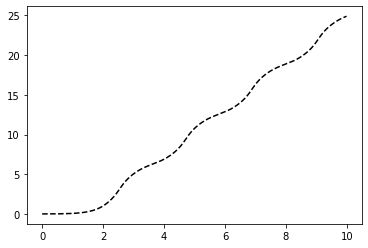

In [22]:
kp, ki, kd = 0.0, 0.0, 0.0
cont = controller.PID((kp, ki, kd))
results = simu10.simulate(pend, cont)
fig1, ax1 = plt.subplots()
ax1.plot(results[('state','t')], 'k--', label='theta')

plt.show()

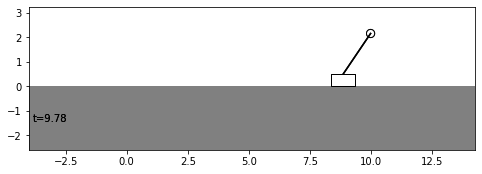

In [23]:
visu = viz.Visualizer(results, pend, dt)
ani = visu.animate()
HTML(ani.to_html5_video())

To tune, we introduce a constant-gain, called ku, that guides the tuning process. We want to start it at zero and slowly increase it until we have a slow, steady oscillation.

So let's create a few controllers, increasing the gain by 0.25 for each. We're interested in stabilizing the pendulum system, so that means we want $\theta$ to settle at 0.

In [24]:
ku = 0.0
n_ku = 32
increase_by = 2.5
conts = []
pends = [pend] * n_ku
gains = []
for i in range(n_ku):
    # increase the gain
    ku += increase_by
    pid = ku, 0.0, 0.0
    conts.append(controller.PID(pid))
    gains.append(ku)
    
all_results = simu10.simulate_multiple(pends, conts)

100%|██████████| 1000/1000 [00:00<00:00, 1764.63it/s]


Now, let's see how $\theta$ is performing for each gain.

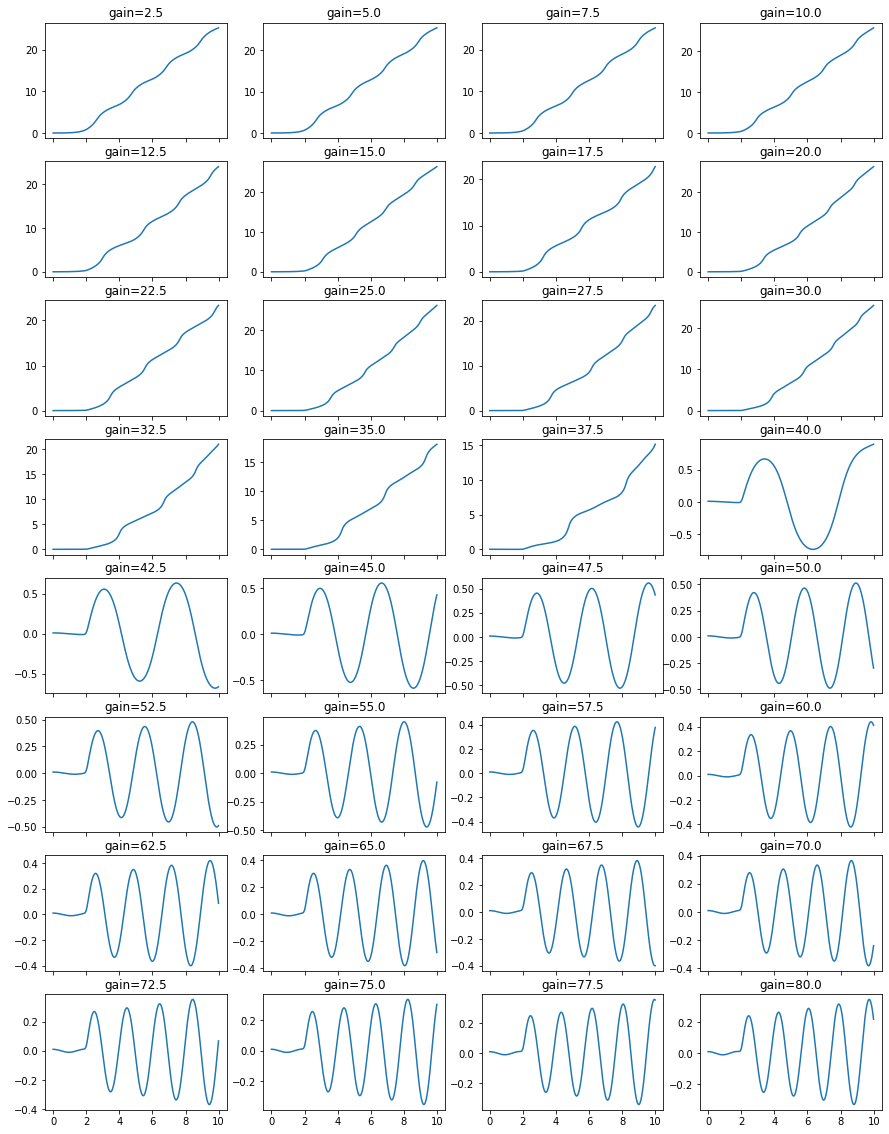

In [25]:
nrows, ncols = 8, 4
fig1, ax1 = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(15,20))
axn, ax_idxs = 0, {}
for i in range(nrows):
    for j in range(ncols):
        ax_idxs[axn] = (i, j)
        axn += 1
for g, (idx, res), (axi, axj) in zip(gains, all_results.groupby(level=0), ax_idxs.values()):
    res.index = res.index.droplevel(0)
    ax1[axi, axj].plot(res[('state', 't')])
    ax1[axi, axj].set_title('gain=' + str(g))
plt.show()

So, here we can see that right around $k_u=50.0$, we get a stabilization of the pendulum, instead of theta getting away faster than the controller can stabilize it. Let's tune a little bit aggressively and set our ultimate gain, $k_u=60.0$.

Now, we have to find the period of this steady oscillation. We can run the simulation again, but this time with a much longer `t_final`, to make sure we can guess the oscillation period accurately, since we have to settle on numerical methods to find it. This also simplifies datastructures a little bit and doesn't take too much time.

We also simulate for 10 seconds so that we can compare our P-controller with later results.

In [26]:
ku = 80.0
cont = controller.PID( (ku, 0, 0) )
simu30 = sim.Simulation(dt, 30, force_func)
res_proportional = simu30.simulate(pend, cont)
res_proportional_10 = simu10.simulate(pend, cont)

100%|██████████| 1000/1000 [00:00<00:00, 2483.75it/s]


$\theta$ oscillates with a dominant frequency whose period is $T_u$. This is clear by taking a closer look at the results of the longer simulation we just made. From here, we can tell also that the simple proportional-only controller is not stable, because the oscillations are increasing in magnitude. At some point, the pendulum will fall over. 

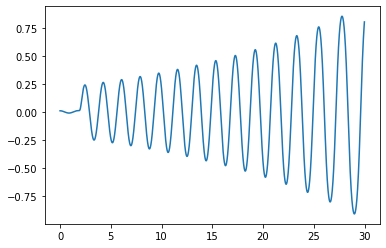

In [27]:
plt.plot(res_proportional[('state', 't')])

Taking and plotting the fourier transform reveals a big spike. Turns out, the imaginary part of this spike is the dominant period $T_u$.

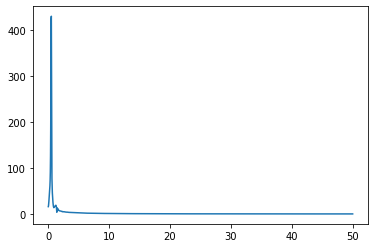

In [28]:
thetas = res_proportional[('state', 't')].values
ft = np.fft.rfft(thetas)
freqs = np.fft.rfftfreq(len(thetas), dt)
mags = abs(ft) 
plt.plot(freqs, mags)

To be sure, we look only at the lower frequencies (so that the chart is cleaner.)

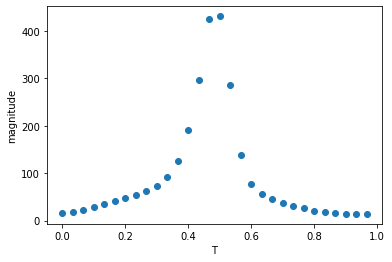

In [29]:
plt.xlabel('T')
plt.ylabel('magnitude')
plt.scatter(freqs[:30], mags[:30])

That big peak starting around $T=0.4$ looks like our dominant period. So we save it. 

In [30]:
tu = freqs[np.argmax(mags)]
print(tu)

0.5


From here, we have the information we need to construct a PD controller. We know that the integral component is not needed, since we can see that the oscillations are centered at $\theta=0$, and therefore, no integral action is needed to bring $\theta$ towards the setpoint of 0.

In [31]:
kp, ki, kd = 0.8 * ku, 0, .10*ku*tu
print(kp, ki, kd)
cont = controller.PID((kp, ki, kd))

64.0 0 4.0


In [32]:
results = simu10.simulate(pend, cont)

100%|██████████| 1000/1000 [00:00<00:00, 2327.13it/s]


Now, we look again at $\theta$. It looks significantly better! The addition of a derivative component drives the oscillations towards zero.

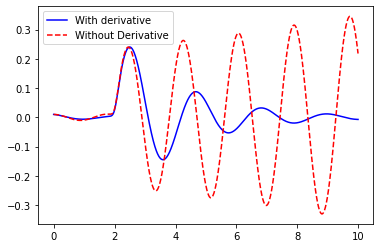

In [33]:
fig, axs = plt.subplots()
axs.plot(results[('state', 't')], 'b-', label='With derivative')
axs.plot(res_proportional_10[('state', 't')], 'r--', label='Without Derivative')
axs.legend()

We see that the addition of the derivative controller slowly brings the oscillation down, and the system becomes far more stable.

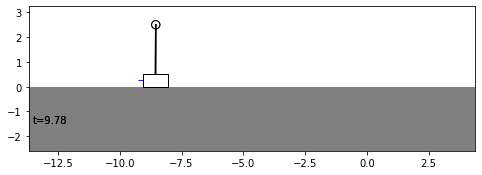

In [34]:
visu = viz.Visualizer(results, pend, dt)
ani = visu.animate(blit=True)
HTML(ani.to_html5_video())

Since this simulation is relatively accurate, we expect that a pendulum with the same attributes (length, mass, etc.), if controlled by a controller with the same gain (as expressed in N of force applied), would have similar stability characteristics.

Tuning a controller in simulation is a common way to implement a controller in a physical system when the consequences of bad tuning can be disasterous. If there were serious consequences to knocking over our pendulum, we would want to use the gains we have discovered here as a starting point.